In [1]:

import networkx as nx
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import requests
from geopy.geocoders import Nominatim
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import math
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
G = nx.read_graphml('../graphs/coauthorship_graph.xml')

In [3]:
df_end = pd.read_csv('../data/processed/aplicacoes/enderecos.csv')
df_pesq = pd.read_csv('../data/processed/aplicacoes/gerais.csv')
df_co = pd.read_csv('../data/processed/aplicacoes/coauthorship_weighted.csv')

In [4]:

max(np.unique(np.array(G.nodes()), return_counts=True)[1])

1

# Análise Dataset

## Gerais

In [6]:
print(f'Shape: {df_pesq.shape}')
print('Contagem de dados nulos:')
display(df_pesq.isna().sum())
print('Amostra do dataset:')
display(df_pesq.head())

Shape: (3992, 9)
Contagem de dados nulos:


LattesID                  0
NOME-COMPLETO             0
DATA-ATUALIZACAO          0
HORA-ATUALIZACAO          0
CIDADE-NASCIMENTO        42
UF-NASCIMENTO           272
PAIS-DE-NASCIMENTO        0
NACIONALIDADE             0
DATA-DE-FALECIMENTO    3992
dtype: int64

Amostra do dataset:


,LattesID,NOME-COMPLETO,DATA-ATUALIZACAO,HORA-ATUALIZACAO,CIDADE-NASCIMENTO,UF-NASCIMENTO,PAIS-DE-NASCIMENTO,NACIONALIDADE,DATA-DE-FALECIMENTO
0,565598534943,Sdnei de Brito Alves,25012007,120204,Itajubá,BA,Brasil,B,NaN
1,601083852823,Alexandre Loureiros Rodrigues,12072021,204404,Vitória,ES,Brasil,B,NaN
2,5349558315095,Juliano Manabu Iyoda,24092021,105006,Recife,PE,Brasil,B,NaN
3,10858860721392,Hugo Bastos de Paula,2032021,83521,Belo Horizonte,MG,Brasil,B,NaN
4,11303079806761,Gerald Jean Francis Banon,3062014,113408,Paris,NaN,França,B,NaN


In [7]:
# ------------------------------------------------------------
# 4. ANÁLISE DESCRITIVA:
#    Exibir as 5 categorias mais frequentes de cada coluna e a contagem
# ------------------------------------------------------------
print("\n=== ANÁLISE DESCRITIVA (TOP 5 POR COLUNA) ===\n")
for col in df_pesq.columns:
    print(f"Coluna: {col}")
    print(df_pesq[col].value_counts(dropna=False).head(5))
    print("-" * 50)


=== ANÁLISE DESCRITIVA (TOP 5 POR COLUNA) ===

Coluna: LattesID
LattesID
565598534943        1
6519916148844251    1
6489257938942420    1
6494676052801758    1
6496119903436467    1
Name: count, dtype: int64
--------------------------------------------------
Coluna: NOME-COMPLETO
NOME-COMPLETO
Sdnei de Brito Alves             1
Ascendino Flávio Dias e Silva    1
Janilson Pinheiro de Assis       1
Adriana Santarosa Vivacqua       1
Paulo Balduino Flabes Neto       1
Name: count, dtype: int64
--------------------------------------------------
Coluna: DATA-ATUALIZACAO
DATA-ATUALIZACAO
4032022     58
30092021    52
2032022     47
27092021    43
24022022    42
Name: count, dtype: int64
--------------------------------------------------
Coluna: HORA-ATUALIZACAO
HORA-ATUALIZACAO
123530    3
113458    3
140714    3
224201    2
141515    2
Name: count, dtype: int64
--------------------------------------------------
Coluna: CIDADE-NASCIMENTO
CIDADE-NASCIMENTO
São Paulo         283
Rio de Janei

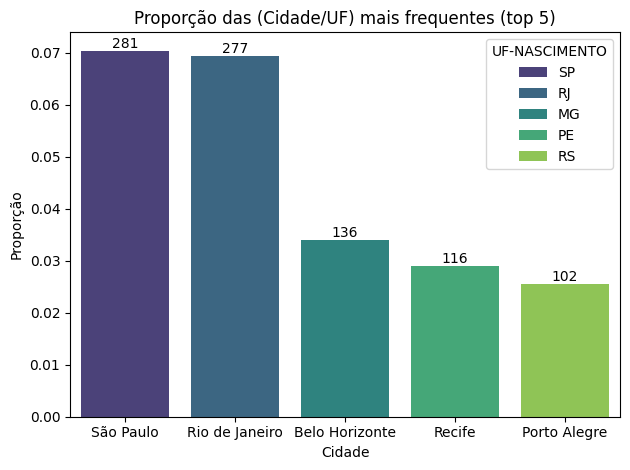

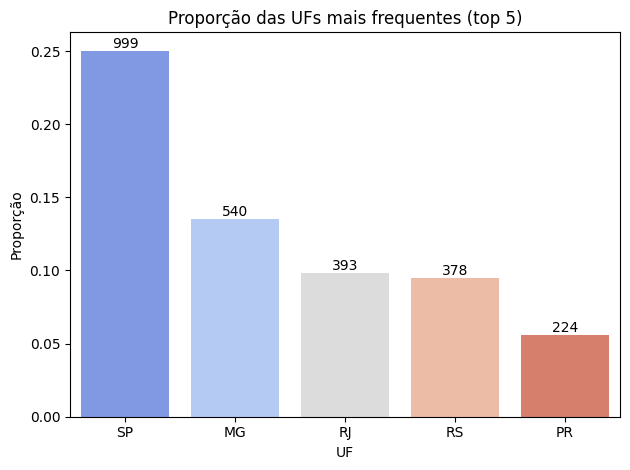

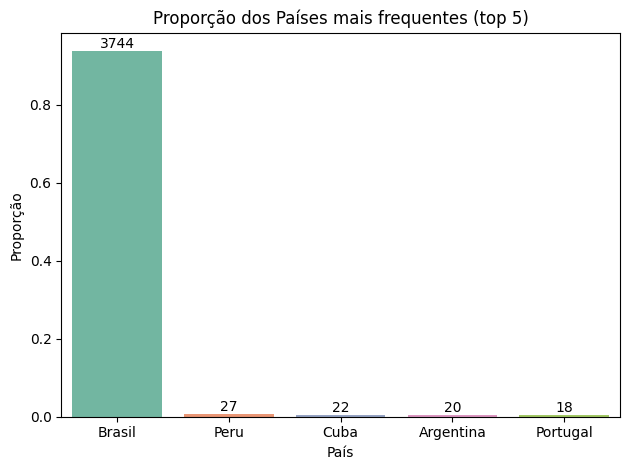

In [13]:
# ------------------------------------------------------------
# Parâmetro: número máximo de categorias (barras) a exibir
# ------------------------------------------------------------
n = 5  # Ajuste conforme necessário (ex: 5, 10, etc.)

# ============================================================
# 1. Gráfico de Barra - (CIDADE-NASCIMENTO, UF-NASCIMENTO)
# ============================================================
df_city_uf = (
    df_pesq
    .groupby(["CIDADE-NASCIMENTO", "UF-NASCIMENTO"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(n)
)
df_city_uf["proportion"] = df_city_uf["count"] / df_pesq.shape[0]

plt.figure()
ax_city_uf = sns.barplot(
    data=df_city_uf,
    x="CIDADE-NASCIMENTO",
    y="proportion",
    hue="UF-NASCIMENTO",  # Aqui já temos o hue definido, logo não há aviso
    palette="viridis"
)
plt.title(f"Proporção das (Cidade/UF) mais frequentes (top {n})")
plt.xlabel("Cidade")
plt.ylabel("Proporção")

# Adicionando a contagem sobre cada barra
for patch, (_, row) in zip(ax_city_uf.patches, df_city_uf.iterrows()):
    height = patch.get_height()
    ax_city_uf.annotate(
        f'{int(row["count"])}',
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center', va='center', textcoords='offset points', xytext=(0, 5)
    )
plt.tight_layout()
plt.show()

# ============================================================
# 2. Gráfico de Barra - UF-NASCIMENTO
# ============================================================
df_uf = (
    df_pesq
    .groupby("UF-NASCIMENTO")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(n)
)
df_uf["proportion"] = df_uf["count"] / df_pesq.shape[0]

plt.figure()
# Para evitar o aviso, utilizamos o mesmo valor de 'UF-NASCIMENTO' para o argumento hue
ax_uf = sns.barplot(
    data=df_uf,
    x="UF-NASCIMENTO",
    y="proportion",
    hue="UF-NASCIMENTO",  # atribuindo hue
    palette="coolwarm"
)
# Remove a legenda para não duplicar informação
if ax_uf.get_legend() is not None:
    ax_uf.get_legend().remove()

plt.title(f"Proporção das UFs mais frequentes (top {n})")
plt.xlabel("UF")
plt.ylabel("Proporção")

for patch, (_, row) in zip(ax_uf.patches, df_uf.iterrows()):
    height = patch.get_height()
    ax_uf.annotate(
        f'{int(row["count"])}', 
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center', va='center', textcoords='offset points', xytext=(0, 5)
    )
plt.tight_layout()
plt.show()

# ============================================================
# 3. Gráfico de Barra - PAIS-NASCIMENTO
# ============================================================
df_pais = (
    df_pesq
    .groupby("PAIS-DE-NASCIMENTO")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(n)
)
df_pais["proportion"] = df_pais["count"] / df_pesq.shape[0]

plt.figure()
# Utilizando o mesmo valor para x e hue para evitar o aviso de palette
ax_pais = sns.barplot(
    data=df_pais,
    x="PAIS-DE-NASCIMENTO",
    y="proportion",
    hue="PAIS-DE-NASCIMENTO",  # atribuindo hue
    palette="Set2"
)
if ax_pais.get_legend() is not None:
    ax_pais.get_legend().remove()

plt.title(f"Proporção dos Países mais frequentes (top {n})")
plt.xlabel("País")
plt.ylabel("Proporção")

for patch, (_, row) in zip(ax_pais.patches, df_pais.iterrows()):
    height = patch.get_height()
    ax_pais.annotate(
        f'{int(row["count"])}',
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center', va='center', textcoords='offset points', xytext=(0, 5)
    )
plt.tight_layout()
plt.show()


## Areas

In [ ]:
df_areas = pd.read_csv('../data/processed/aplicacoes/areas.csv')


In [14]:

print(f'Shape: {df_areas.shape}')
print('Contagem de dados nulos:')
display(df_areas.isna().sum())
print('Amostra do dataset:')
display(df_areas.head())

Shape: (16286, 6)
Contagem de dados nulos:


LattesID                               0
SEQUENCIA-AREA-DE-ATUACAO             26
NOME-GRANDE-AREA-DO-CONHECIMENTO       0
NOME-DA-AREA-DO-CONHECIMENTO          28
NOME-DA-SUB-AREA-DO-CONHECIMENTO    1462
NOME-DA-ESPECIALIDADE               8050
dtype: int64

Amostra do dataset:


,LattesID,SEQUENCIA-AREA-DE-ATUACAO,NOME-GRANDE-AREA-DO-CONHECIMENTO,NOME-DA-AREA-DO-CONHECIMENTO,NOME-DA-SUB-AREA-DO-CONHECIMENTO,NOME-DA-ESPECIALIDADE
0,565598534943,5.0,CIENCIAS_EXATAS_E_DA_TERRA,Ciência da Computação,Metodologia e Técnicas da Computação,Linguagens de Programação
1,565598534943,4.0,CIENCIAS_EXATAS_E_DA_TERRA,Ciência da Computação,Processamento de Imagens,Visão Robótica
2,565598534943,3.0,CIENCIAS_EXATAS_E_DA_TERRA,Ciência da Computação,Processamento de Imagens,Visão Computacional Aplicada
3,565598534943,2.0,CIENCIAS_EXATAS_E_DA_TERRA,Ciência da Computação,Metodologia e Técnicas da Computação,Sistemas de Informação
4,565598534943,1.0,CIENCIAS_EXATAS_E_DA_TERRA,Ciência da Computação,Metodologia e Técnicas da Computação,Engenharia de Software


In [15]:
# Lista das colunas que vamos analisar, excluindo 'LattesID'
cols_to_analyze = [col for col in df_areas.columns if col != "LattesID"]

In [16]:
# ------------------------------------------------------------
# ANÁLISE DESCRITIVA (TOP 5 POR COLUNA)
# ------------------------------------------------------------
print("\n=== ANÁLISE DESCRITIVA (TOP 5 POR COLUNA) ===\n")
for col in cols_to_analyze:
    print(f"Coluna: {col}")
    print(df_areas[col].value_counts(dropna=False).head(5))
    print("-" * 50)


=== ANÁLISE DESCRITIVA (TOP 5 POR COLUNA) ===

Coluna: SEQUENCIA-AREA-DE-ATUACAO
SEQUENCIA-AREA-DE-ATUACAO
1.0    3908
2.0    3715
3.0    3301
4.0    2561
5.0    1759
Name: count, dtype: int64
--------------------------------------------------
Coluna: NOME-GRANDE-AREA-DO-CONHECIMENTO
NOME-GRANDE-AREA-DO-CONHECIMENTO
CIENCIAS_EXATAS_E_DA_TERRA    6530
ENGENHARIAS                   3122
CIENCIAS_AGRARIAS             2212
CIENCIAS_BIOLOGICAS           1261
CIENCIAS_SOCIAIS_APLICADAS    1063
Name: count, dtype: int64
--------------------------------------------------
Coluna: NOME-DA-AREA-DO-CONHECIMENTO
NOME-DA-AREA-DO-CONHECIMENTO
Ciência da Computação    4862
Engenharia Elétrica      1514
Agronomia                 772
Ciência da Informação     641
Medicina Veterinária      498
Name: count, dtype: int64
--------------------------------------------------
Coluna: NOME-DA-SUB-AREA-DO-CONHECIMENTO
NOME-DA-SUB-AREA-DO-CONHECIMENTO
Metodologia e Técnicas da Computação    1608
NaN              

/tmp/ipykernel_32302/166781012.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


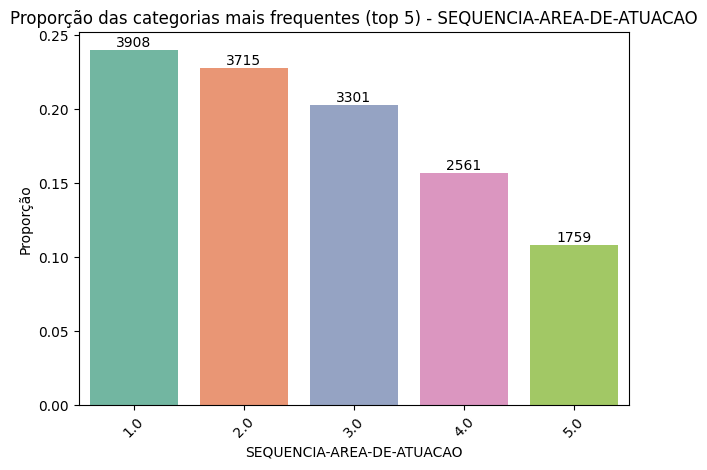

/tmp/ipykernel_32302/166781012.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


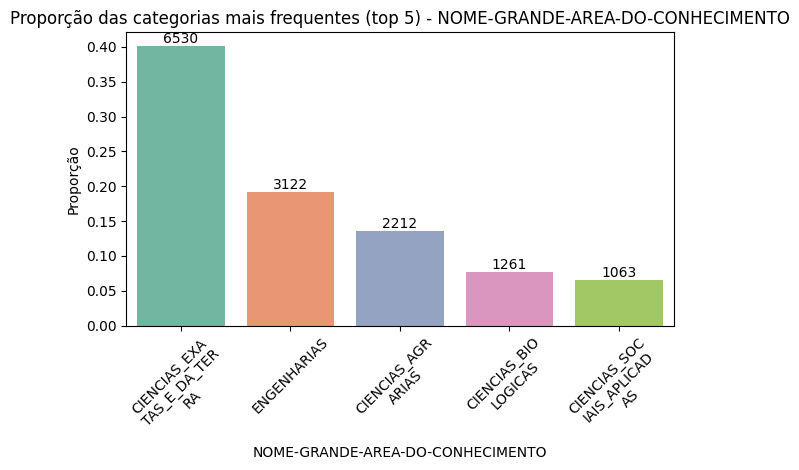

/tmp/ipykernel_32302/166781012.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


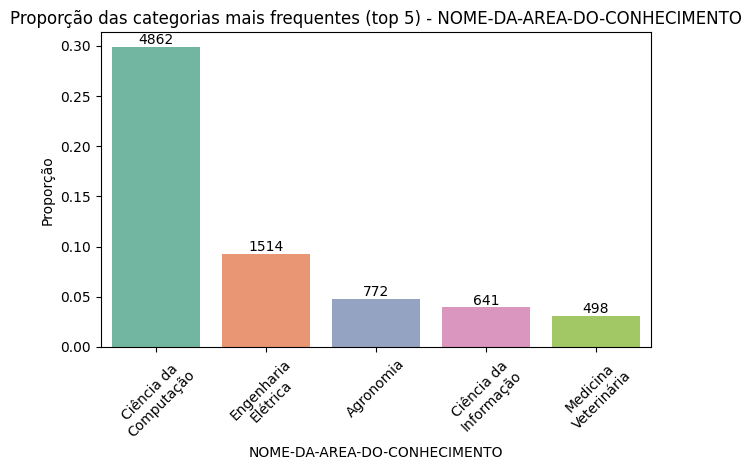

/tmp/ipykernel_32302/166781012.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


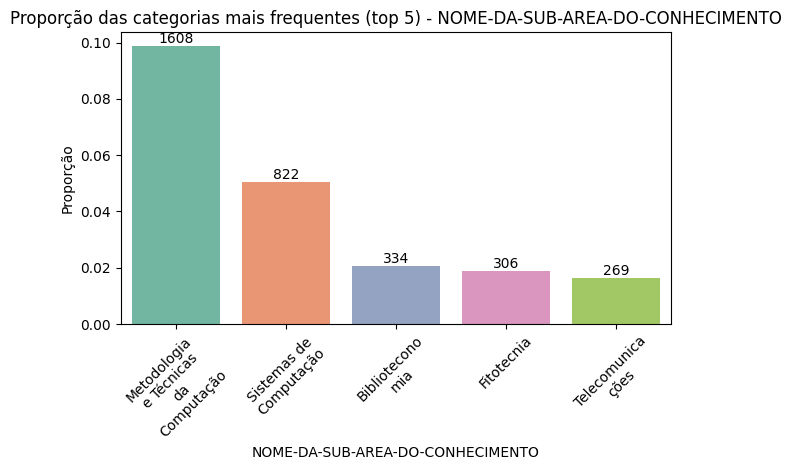

/tmp/ipykernel_32302/166781012.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


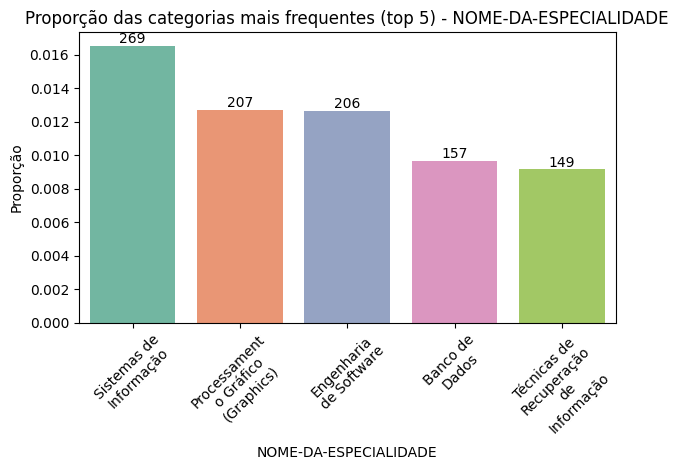

In [20]:
import textwrap


# -------------------------------------------------------------------
# Parâmetro: número máximo de categorias (barras) a exibir nos gráficos
# -------------------------------------------------------------------
n = 5

# Função para quebrar (wrap) os rótulos longos em múltiplas linhas
def wrap_labels(label, width=12):
    return "\n".join(textwrap.wrap(label, width=width))

# -------------------------------------------------------------------
# Geração dos gráficos de barras para cada coluna analisada
# -------------------------------------------------------------------
for col in cols_to_analyze:
    # Agrupa e conta as ocorrências para a coluna atual e seleciona as top n
    df_grouped = (
        df_areas
        .groupby(col)
        .size()
        .reset_index(name="count")
        .sort_values("count", ascending=False)
        .head(n)
    )
    # Calcula a proporção (em relação ao total do DataFrame)
    df_grouped["proportion"] = df_grouped["count"] / df_areas.shape[0]

    # Cria o gráfico utilizando Seaborn (não fixa o tamanho da figura)
    plt.figure()
    ax = sns.barplot(
        data=df_grouped,
        x=col,
        y="proportion",
        hue=col,       # utiliza a mesma coluna para atribuir cores
        palette="Set2" # ou outro palette de sua preferência
    )
    # Remove a legenda, pois o hue é idêntico ao eixo x
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    plt.title(f"Proporção das categorias mais frequentes (top {n}) - {col}")
    plt.xlabel(col)
    plt.ylabel("Proporção")

    # Ajusta os rótulos do eixo x:
    # 1) Aplica uma rotação de 45°.
    # 2) Quebra (wrap) os rótulos para evitar sobreposição de textos longos.
    new_labels = [wrap_labels(label.get_text(), width=12) 
                  for label in ax.get_xticklabels()]
    ax.set_xticklabels(new_labels, rotation=45)

    # Adiciona as anotações (contagem) acima de cada barra
    for patch, (_, row) in zip(ax.patches, df_grouped.iterrows()):
        height = patch.get_height()
        ax.annotate(
            f'{int(row["count"])}',
            (patch.get_x() + patch.get_width() / 2., height),
            ha='center', va='center',
            textcoords='offset points', xytext=(0, 5)
        )

    plt.tight_layout()
    plt.show()


## Formações

In [25]:
df_forms = pd.read_csv('../data/processed/aplicacoes/formacoes.csv')

In [26]:

print(f'Shape: {df_forms.shape}')
print('Contagem de dados nulos:')
display(df_forms.isna().sum())
print('Amostra do dataset:')
display(df_forms.head())

Shape: (18236, 10)
Contagem de dados nulos:


LattesID                 0
SEQUENCIA-FORMACAO       0
NIVEL-FORMACAO           0
NIVEL                    0
ANO-DE-INICIO          382
ANO-DE-CONCLUSAO       793
STATUS-DO-CURSO        370
NOME-CURSO            3690
NOME-INSTITUICAO         5
FLAG-BOLSA             912
dtype: int64

Amostra do dataset:


,LattesID,SEQUENCIA-FORMACAO,NIVEL-FORMACAO,NIVEL,ANO-DE-INICIO,ANO-DE-CONCLUSAO,STATUS-DO-CURSO,NOME-CURSO,NOME-INSTITUICAO,FLAG-BOLSA
0,565598534943,4,DOUTORADO,4,1987,1992,CONCLUIDO,Computação Aplicada,Instituto Nacional de Pesquisas Espaciais,NAO
1,565598534943,3,MESTRADO,3,1975,1976,CONCLUIDO,Engenharia de Sistemas e Computação,Universidade Federal do Rio de Janeiro,NAO
2,565598534943,1,GRADUACAO,1,1970,1974,CONCLUIDO,Bacharelado Em Estatística,Escola Superior de Estatística da Bahia,NAO
3,601083852823,4,DOUTORADO,4,2006,2009,CONCLUIDO,Estatística,Lancaster University,SIM
4,601083852823,3,MESTRADO,3,2003,2005,CONCLUIDO,Estatística,Universidade Federal de Minas Gerais,SIM


In [28]:
# Lista das colunas a serem analisadas (excluindo 'LattesID')
cols_to_analyze = [col for col in df_forms.columns if col != "LattesID"]


In [29]:
# -----------------------------------------------------------------------------
# Análise Descritiva: exibe os 5 valores mais frequentes para cada coluna
# (exceto LattesID)
# -----------------------------------------------------------------------------
print("\n=== ANÁLISE DESCRITIVA (TOP 5 POR COLUNA) ===\n")
for col in cols_to_analyze:
    print(f"Coluna: {col}")
    print(df_forms[col].value_counts(dropna=False).head(5))
    print("-" * 50)


=== ANÁLISE DESCRITIVA (TOP 5 POR COLUNA) ===

Coluna: SEQUENCIA-FORMACAO
SEQUENCIA-FORMACAO
1    3470
2    3130
3    2796
4    1817
5    1165
Name: count, dtype: int64
--------------------------------------------------
Coluna: NIVEL-FORMACAO
NIVEL-FORMACAO
GRADUACAO         4482
DOUTORADO         4088
MESTRADO          3814
POS-DOUTORADO     2427
ESPECIALIZACAO    1533
Name: count, dtype: int64
--------------------------------------------------
Coluna: NIVEL
NIVEL
1    4482
4    4088
3    3814
5    2427
2    1533
Name: count, dtype: int64
--------------------------------------------------
Coluna: ANO-DE-INICIO
ANO-DE-INICIO
2000    566
2005    562
2008    550
2001    548
2004    548
Name: count, dtype: int64
--------------------------------------------------
Coluna: ANO-DE-CONCLUSAO
ANO-DE-CONCLUSAO
NaN     793
2005    612
2003    605
2008    593
2006    578
Name: count, dtype: int64
--------------------------------------------------
Coluna: STATUS-DO-CURSO
STATUS-DO-CURSO
CONCLUIDO 

/tmp/ipykernel_32302/326409561.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


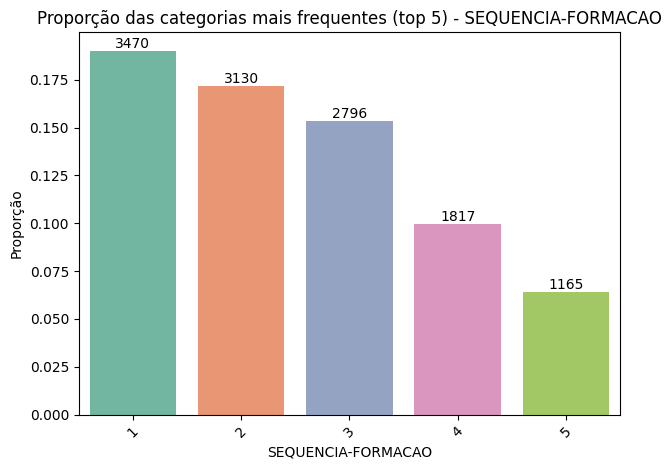

/tmp/ipykernel_32302/326409561.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


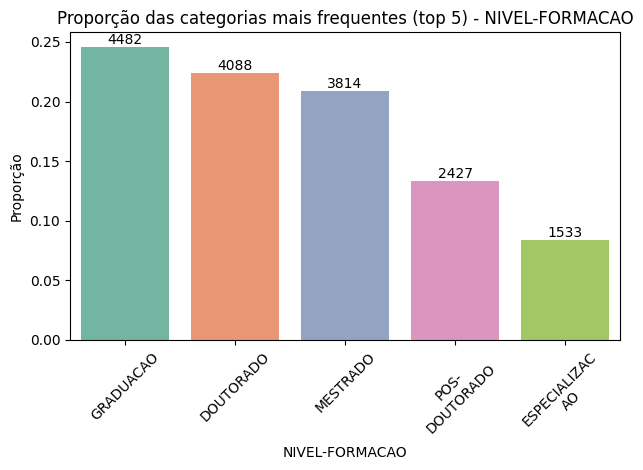

/tmp/ipykernel_32302/326409561.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


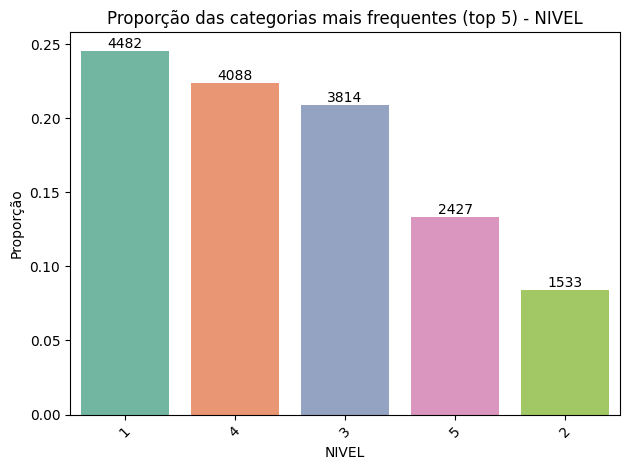

/tmp/ipykernel_32302/326409561.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


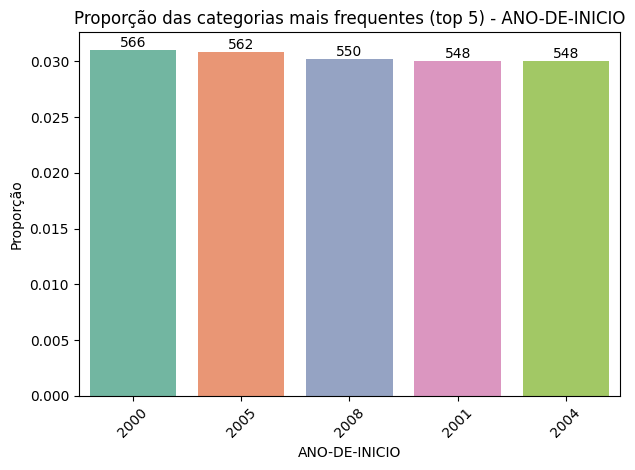

/tmp/ipykernel_32302/326409561.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


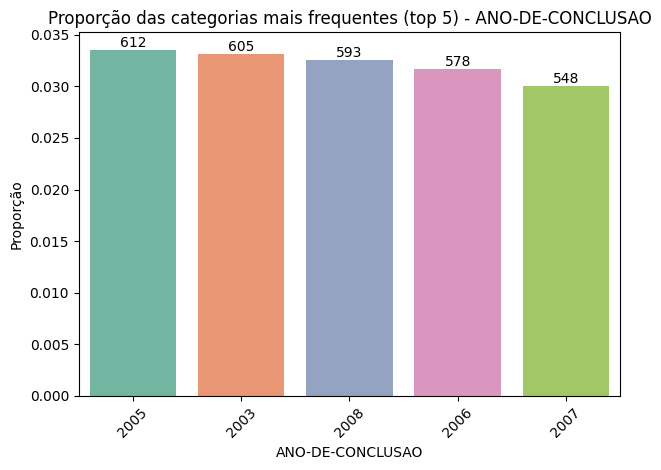

/tmp/ipykernel_32302/326409561.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


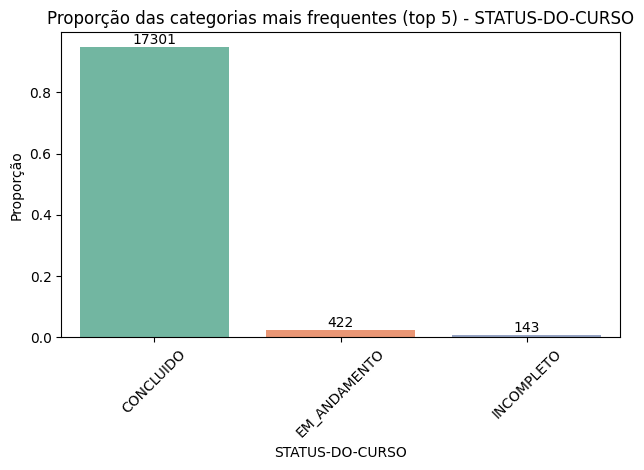

/tmp/ipykernel_32302/326409561.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


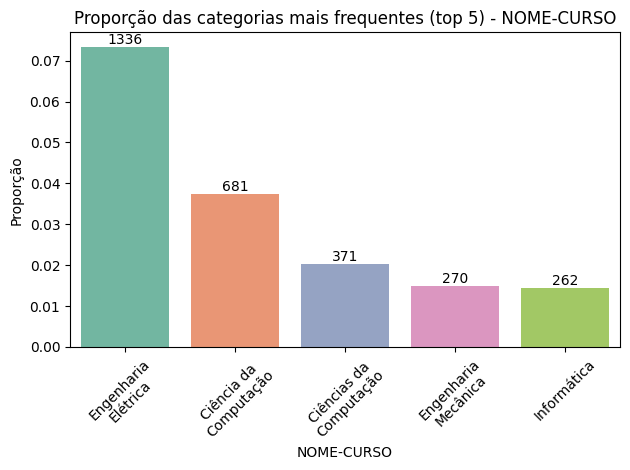

/tmp/ipykernel_32302/326409561.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


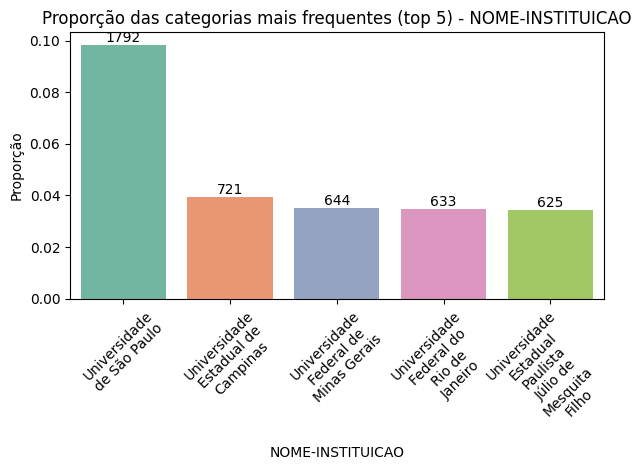

/tmp/ipykernel_32302/326409561.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


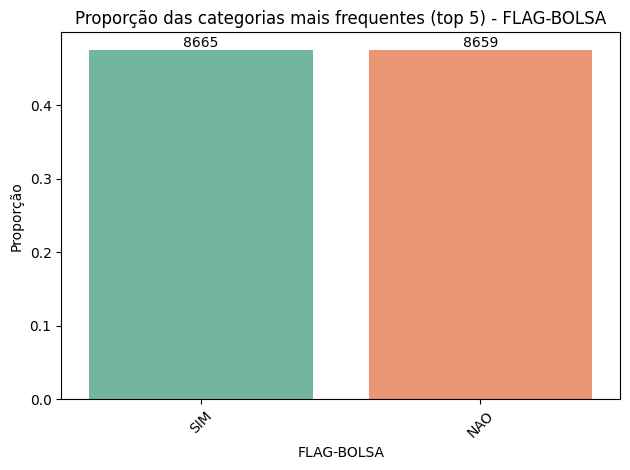

In [30]:
# -----------------------------------------------------------------------------
# Configuração: número máximo de categorias (barras) a exibir em cada gráfico
# -----------------------------------------------------------------------------
n = 5

# Função para quebrar (wrap) rótulos longos em múltiplas linhas
def wrap_labels(label, width=12):
    return "\n".join(textwrap.wrap(label, width=width))

# -----------------------------------------------------------------------------
# Geração dos gráficos de barras (top n) para cada coluna analisada
# -----------------------------------------------------------------------------
for col in cols_to_analyze:
    # Agrupa os dados por coluna, conta a frequência e seleciona top n
    df_grouped = (
        df_forms
        .groupby(col)
        .size()
        .reset_index(name="count")
        .sort_values("count", ascending=False)
        .head(n)
    )
    # Calcula a proporção em relação ao total de linhas do df_forms
    df_grouped["proportion"] = df_grouped["count"] / df_forms.shape[0]

    # Cria o gráfico de barras com Seaborn (sem tamanho fixo de figura)
    plt.figure()
    ax = sns.barplot(
        data=df_grouped,
        x=col,
        y="proportion",
        hue=col,         # usa a própria coluna como hue para colorir cada categoria
        palette="Set2"   # escolha a paleta desejada
    )
    # Remove a legenda (pois hue = col repete os valores do eixo x)
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    plt.title(f"Proporção das categorias mais frequentes (top {n}) - {col}")
    plt.xlabel(col)
    plt.ylabel("Proporção")

    # Ajusta os rótulos do eixo x: rotação e quebra de linha para evitar sobreposição
    new_labels = [wrap_labels(label.get_text(), width=12) for label in ax.get_xticklabels()]
    ax.set_xticklabels(new_labels, rotation=45)

    # Adiciona as contagens em cima de cada barra
    for patch, (_, row) in zip(ax.patches, df_grouped.iterrows()):
        height = patch.get_height()
        ax.annotate(
            f'{int(row["count"])}',
            (patch.get_x() + patch.get_width() / 2., height),
            ha='center', va='center',
            xytext=(0, 5),  # deslocamento vertical
            textcoords='offset points'
        )

    plt.tight_layout()
    plt.show()




## Endereços

In [33]:

print(f'Shape: {df_end.shape}')
print('Contagem de dados nulos:')
display(df_end.isna().sum())
print('Amostra do dataset:')
display(df_end.head())

Shape: (3644, 11)
Contagem de dados nulos:


LattesID                         0
PAIS                             0
UF                              98
CIDADE                           1
CEP                             26
CODIGO-INSTITUICAO-EMPRESA      15
NOME-INSTITUICAO-EMPRESA        16
CODIGO-UNIDADE                2216
NOME-UNIDADE                  2216
CODIGO-ORGAO                   381
NOME-ORGAO                     381
dtype: int64

Amostra do dataset:


,LattesID,PAIS,UF,CIDADE,CEP,CODIGO-INSTITUICAO-EMPRESA,NOME-INSTITUICAO-EMPRESA,CODIGO-UNIDADE,NOME-UNIDADE,CODIGO-ORGAO,NOME-ORGAO
0,11303079806761,Brasil,SP,Sao Jose dos Campos,12227-010,008700000009,Instituto Nacional de Pesquisas Espaciais,008701001998,Divisão de Processamento de Imagens,008701000991,Coordenação Geral de Observação da Terra
1,29713017048136,Brasil,PR,Maringa,87020900,032900000005,Universidade Estadual de Maringá,NaN,NaN,032902000002,Centro de Ciências Exatas
2,10858860721392,Brasil,MG,Belo Horizonte,31980110,117800000006,Pontifícia Universidade Católica de Minas Gerais,117801001995,Sistemas de Informação,117801000999,Instituto de Informática
3,77465042842971,Brasil,MG,João Monlevade,35931026,033400000004,Universidade Federal de Ouro Preto,NaN,NaN,NaN,NaN
4,57571113012412,Brasil,SP,Sao Paulo,05508-010,006700000002,Universidade de São Paulo,006716001992,Departamento de Engenharia de Sistemas Eletrôn...,006716000007,Escola Politécnica


In [34]:
# -------------------------------------------------------------------------
# 3. ANÁLISE DESCRITIVA: TOP 5 CATEGORIAS PARA AS COLUNAS
#    `NOME-INSTITUICAO-EMPRESA` e `NOME-ORGAO`.
# -------------------------------------------------------------------------
print("\n=== ANÁLISE DESCRITIVA (TOP 5) ===\n")
columns_to_analyze = ["NOME-INSTITUICAO-EMPRESA", "NOME-ORGAO"]

for col in columns_to_analyze:
    print(f"Coluna: {col}")
    print(df_end[col].value_counts(dropna=False).head(5))
    print("-" * 50)


=== ANÁLISE DESCRITIVA (TOP 5) ===

Coluna: NOME-INSTITUICAO-EMPRESA
NOME-INSTITUICAO-EMPRESA
Universidade de São Paulo                                 259
Universidade Estadual Paulista Júlio de Mesquita Filho    118
Universidade Federal de Minas Gerais                      111
Universidade Federal do Rio de Janeiro                     92
Universidade Federal de Pernambuco                         86
Name: count, dtype: int64
--------------------------------------------------
Coluna: NOME-ORGAO
NOME-ORGAO
NaN                             381
Centro de Tecnologia             62
Centro Tecnológico               59
Instituto de Ciências Exatas     54
Escola Politécnica               53
Name: count, dtype: int64
--------------------------------------------------


/tmp/ipykernel_32302/4238293866.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_inst.set_xticklabels(new_labels, rotation=45)


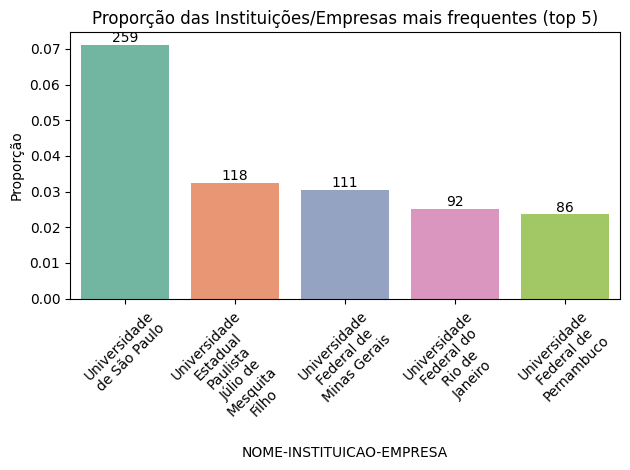

/tmp/ipykernel_32302/4238293866.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_orgao.set_xticklabels(new_labels, rotation=45)


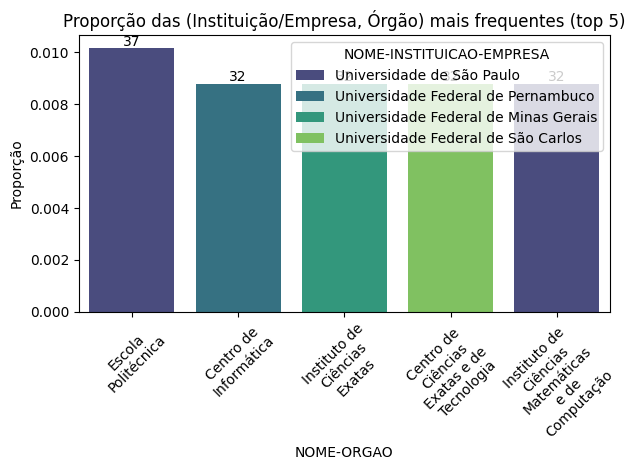

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

n = 5  # Ajuste conforme desejar (por exemplo, 5, 10 etc.)

# -------------------------------------------------------------------------
# Função para "quebrar" (wrap) rótulos longos em múltiplas linhas
# -------------------------------------------------------------------------
def wrap_labels(label, width=12):
    return "\n".join(textwrap.wrap(label, width=width))

# -------------------------------------------------------------------------
# 1. GRÁFICO DE BARRA PARA `NOME-INSTITUICAO-EMPRESA` (top n)
# -------------------------------------------------------------------------
df_instituicao = (
    df_end
    .groupby("NOME-INSTITUICAO-EMPRESA")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(n)
)
df_instituicao["proportion"] = df_instituicao["count"] / df_end.shape[0]

plt.figure()
ax_inst = sns.barplot(
    data=df_instituicao,
    x="NOME-INSTITUICAO-EMPRESA",
    y="proportion",
    hue="NOME-INSTITUICAO-EMPRESA",  # usa a própria coluna para dar cor
    palette="Set2"
)
# Remove a legenda redundante
if ax_inst.get_legend() is not None:
    ax_inst.get_legend().remove()

plt.title(f"Proporção das Instituições/Empresas mais frequentes (top {n})")
plt.xlabel("NOME-INSTITUICAO-EMPRESA")
plt.ylabel("Proporção")

# Ajusta rótulos do eixo x: rotação + quebra de linha
new_labels = [wrap_labels(label.get_text(), width=12) for label in ax_inst.get_xticklabels()]
ax_inst.set_xticklabels(new_labels, rotation=45)

# Anota as contagens sobre cada barra
for patch, (_, row) in zip(ax_inst.patches, df_instituicao.iterrows()):
    height = patch.get_height()
    ax_inst.annotate(
        f'{int(row["count"])}',
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 2. GRÁFICO DE BARRA PARA O PAR (`NOME-INSTITUICAO-EMPRESA`, `NOME-ORGAO`) (top n)
#    Este é análogo a (Cidade, UF) em exemplos anteriores.
# -------------------------------------------------------------------------
df_orgao = (
    df_end
    .groupby(["NOME-INSTITUICAO-EMPRESA", "NOME-ORGAO"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(n)
)
df_orgao["proportion"] = df_orgao["count"] / df_end.shape[0]

plt.figure()
ax_orgao = sns.barplot(
    data=df_orgao,
    x="NOME-ORGAO",
    y="proportion",
    hue="NOME-INSTITUICAO-EMPRESA",   # cor baseada na Instituição/Empresa
    palette="viridis"
)
plt.title(f"Proporção das (Instituição/Empresa, Órgão) mais frequentes (top {n})")
plt.xlabel("NOME-ORGAO")
plt.ylabel("Proporção")

# Rótulos do eixo x: rotação + wrap
new_labels = [wrap_labels(label.get_text(), width=12) for label in ax_orgao.get_xticklabels()]
ax_orgao.set_xticklabels(new_labels, rotation=45)

# Adiciona as contagens
for patch, (_, row) in zip(ax_orgao.patches, df_orgao.iterrows()):
    height = patch.get_height()
    ax_orgao.annotate(
        f'{int(row["count"])}',
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

## Linhas

In [36]:
df_linhas = pd.read_csv('../data/processed/aplicacoes/linhas.csv')

In [37]:
print(f'Shape: {df_linhas.shape}')
print('Contagem de dados nulos:')
display(df_linhas.isna().sum())
print('Amostra do dataset:')
display(df_linhas.head())

Shape: (7271, 15)
Contagem de dados nulos:


LattesID                               0
TITULO-DA-LINHA-DE-PESQUISA            1
OBJETIVOS-LINHA-DE-PESQUISA         2935
FLAG-LINHA-DE-PESQUISA-ATIVA           0
PALAVRA-CHAVE-1                     2820
PALAVRA-CHAVE-2                     3122
PALAVRA-CHAVE-3                     3745
PALAVRA-CHAVE-4                     4922
PALAVRA-CHAVE-5                     5777
SETOR-DE-ATIVIDADE-1                4690
SETOR-DE-ATIVIDADE-2                6335
NOME-GRANDE-AREA-DO-CONHECIMENTO    3359
NOME-DA-AREA-DO-CONHECIMENTO        7089
NOME-DA-SUB-AREA-DO-CONHECIMENTO    4373
NOME-DA-ESPECIALIDADE               5620
dtype: int64

Amostra do dataset:


,LattesID,TITULO-DA-LINHA-DE-PESQUISA,OBJETIVOS-LINHA-DE-PESQUISA,FLAG-LINHA-DE-PESQUISA-ATIVA,PALAVRA-CHAVE-1,PALAVRA-CHAVE-2,PALAVRA-CHAVE-3,PALAVRA-CHAVE-4,PALAVRA-CHAVE-5,SETOR-DE-ATIVIDADE-1,SETOR-DE-ATIVIDADE-2,NOME-GRANDE-AREA-DO-CONHECIMENTO,NOME-DA-AREA-DO-CONHECIMENTO,NOME-DA-SUB-AREA-DO-CONHECIMENTO,NOME-DA-ESPECIALIDADE
0,11303079806761,ASPECTS STOCHASTIQUES DE L'AUTOMATIQUE,NaN,NAO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11303079806761,Morfologia matemática,NaN,NAO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11303079806761,Processamento digital de imagens,NaN,NAO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,51564735964760,Teorias das Singularidades,NaN,SIM,NaN,NaN,NaN,NaN,NaN,Educação,NaN,CIENCIAS_EXATAS_E_DA_TERRA,NaN,Geometria e Topologia,Teoria das Singularidades e Teoria das Catástr...
4,32127633683659,Produção de sentido no texto/discurso,Examinar tanto os procedimentos de organização...,NAO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LINGUISTICA_LETRAS_E_ARTES,NaN,Teoria e Análise Lingüística,NaN


TEM POUQUISSIMO DADO NAO NULO, VALE ANALISE?

In [38]:
# ===================================
# 2. ANÁLISE DESCRITIVA
#    (TOP 5 valores da coluna)
# ===================================
print("\n=== ANÁLISE DESCRITIVA (TOP 5) - TITULO-DA-LINHA-DE-PESQUISA ===\n")
print(df_linhas["TITULO-DA-LINHA-DE-PESQUISA"].value_counts(dropna=False).head(5))
print("-" * 50)


=== ANÁLISE DESCRITIVA (TOP 5) - TITULO-DA-LINHA-DE-PESQUISA ===

TITULO-DA-LINHA-DE-PESQUISA
Visão Computacional          63
Inteligência Artificial      51
Reconhecimento de Padrões    32
Processamento de Imagens     28
Engenharia de Software       21
Name: count, dtype: int64
--------------------------------------------------


/tmp/ipykernel_32302/1711134032.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


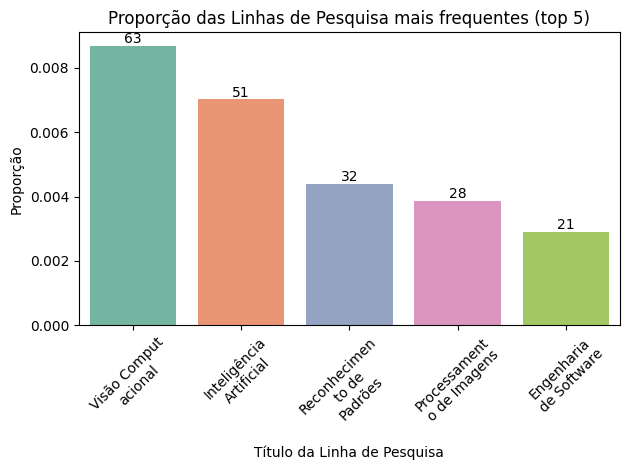

In [39]:
# ===================================
# Parâmetro: número de categorias (barras) a exibir
# ===================================
n = 5  # ajuste conforme necessário (ex: 5, 10 etc.)

# ===================================
# Função para quebrar (wrap) rótulos longos
# ===================================
def wrap_labels(label, width=12):
    return "\n".join(textwrap.wrap(label, width=width))

# ===================================
# 1. AGRUPAMENTO E GRÁFICO DE BARRA
#    para a coluna `TITULO-DA-LINHA-DE-PESQUISA`
# ===================================
df_titulo = (
    df_linhas
    .groupby("TITULO-DA-LINHA-DE-PESQUISA")  # agrupa pela coluna
    .size()                                 # conta quantas vezes cada valor ocorre
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(n)
)
# Calcula a proporção em relação ao total de registros do df_linhas
df_titulo["proportion"] = df_titulo["count"] / df_linhas.shape[0]

# Criando o gráfico de barras
plt.figure()  # não definimos figsize para deixar livre
ax = sns.barplot(
    data=df_titulo,
    x="TITULO-DA-LINHA-DE-PESQUISA",
    y="proportion",
    hue="TITULO-DA-LINHA-DE-PESQUISA",  # usar a própria coluna como hue
    palette="Set2"                      # escolha uma paleta de cores
)
# Removemos a legenda, pois seria redundante (hue = x)
if ax.get_legend() is not None:
    ax.get_legend().remove()

# Título e rótulos
plt.title(f"Proporção das Linhas de Pesquisa mais frequentes (top {n})")
plt.xlabel("Título da Linha de Pesquisa")
plt.ylabel("Proporção")

# Ajuste dos rótulos do eixo x: rotação e quebra de texto longo
new_labels = [wrap_labels(label.get_text(), width=12) for label in ax.get_xticklabels()]
ax.set_xticklabels(new_labels, rotation=45)

# Adicionando as contagens em cima de cada barra
for patch, (_, row) in zip(ax.patches, df_titulo.iterrows()):
    height = patch.get_height()
    ax.annotate(
        f'{int(row["count"])}',
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

## Projetos

In [41]:
df_proj = pd.read_csv('../data/processed/aplicacoes/projetos.csv')

In [42]:
print(f'Shape: {df_proj.shape}')
print('Contagem de dados nulos:')
display(df_proj.isna().sum())
print('Amostra do dataset:')
display(df_proj.head())

Shape: (53045, 14)
Contagem de dados nulos:


LattesID                  0
NATUREZA               1067
SITUACAO               1067
NOME-DO-PROJETO        1067
ANO-INICIO                5
ANO-FIM               15572
FLAG-RESPONSAVEL       1097
CODIGO-INSTITUICAO    24684
NOME-INSTITUICAO      24684
CODIGO-UNIDADE        36825
NOME-UNIDADE          36825
CODIGO-ORGAO            114
NOME-ORGAO              114
INTEGRANTES            1096
dtype: int64

Amostra do dataset:


,LattesID,NATUREZA,SITUACAO,NOME-DO-PROJETO,ANO-INICIO,ANO-FIM,FLAG-RESPONSAVEL,CODIGO-INSTITUICAO,NOME-INSTITUICAO,CODIGO-UNIDADE,NOME-UNIDADE,CODIGO-ORGAO,NOME-ORGAO,INTEGRANTES
0,29713017048136,EXTENSAO,CONCLUIDO,Projeto de Aperfeiçoamento de professores de m...,1997.0,1998.0,NAO,037700000002,Fundação de Amparo à Pesquisa do Estado de São...,033012006005,Departamento de Educação,033012000007,Faculdade de Ciências e Tecnologia de Presiden...,Vinicio de Macedo Santos#Eniuce Menezes de Souza
1,29713017048136,EXTENSAO,CONCLUIDO,Programa de Acompanhamento dos alunos dos curs...,2001.0,2001.0,NAO,037700000002,Fundação de Amparo à Pesquisa do Estado de São...,033012005009,Departamento de Matemática,033012000007,Faculdade de Ciências e Tecnologia de Presiden...,Aparecida Doniseti Pires de Souza#Eniuce Menez...
2,29713017048136,PESQUISA,EM_ANDAMENTO,ANÁLISE WAVELET: DETECÇÃO E REDUÇÃO DO MULTICA...,2004.0,NaN,NAO,037700000002,Fundação de Amparo à Pesquisa do Estado de São...,033012004002,Departamento de Cartografia,033012000007,Faculdade de Ciências e Tecnologia de Presiden...,Guilherme Polezuk S Rosa#Luiz Fernando Dalbell...
3,29713017048136,PESQUISA,CONCLUIDO,Countering the Effects of Ionospheric Scintill...,2007.0,NaN,NAO,037700000002,Fundação de Amparo à Pesquisa do Estado de São...,NaN,NaN,033012000007,Faculdade de Ciências e Tecnologia de Presiden...,Marcio Aquino#Haroldo Antonio Marques#Heloísa ...
4,29713017048136,PESQUISA,CONCLUIDO,Projeto Temático FAPESP - GNSS: investigações ...,2008.0,2012.0,NAO,037700000002,Fundação de Amparo à Pesquisa do Estado de São...,NaN,NaN,033012000007,Faculdade de Ciências e Tecnologia de Presiden...,Paulo de Oliveira Camargo#João Francisco Galer...


GOSTARIA DE CONTAR OS NOMES DOS INTEGRANTES, MAS COMO FAZER ISSO DADO QUE TEM DUPLICATAS DE PROJETOS?

In [44]:
# --------------------------------------------------------------------
# 6. Análise Descritiva: TOP 5 em `NATUREZA` e `SITUAÇÃO`
# --------------------------------------------------------------------
print("\n=== ANÁLISE DESCRITIVA (TOP 5) ===\n")

cols_to_analyze = ["NATUREZA", "SITUACAO"]
for col in cols_to_analyze:
    print(f"Coluna: {col}")
    print(df_proj[col].value_counts(dropna=False).head(5))
    print("-" * 50)



=== ANÁLISE DESCRITIVA (TOP 5) ===

Coluna: NATUREZA
NATUREZA
PESQUISA           39999
EXTENSAO            5243
DESENVOLVIMENTO     4727
OUTRA               1632
NaN                 1067
Name: count, dtype: int64
--------------------------------------------------
Coluna: SITUACAO
SITUACAO
CONCLUIDO       34853
EM_ANDAMENTO    16378
NaN              1067
DESATIVADO        747
Name: count, dtype: int64
--------------------------------------------------


/tmp/ipykernel_32302/81763666.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_nat.set_xticklabels(new_labels, rotation=45)


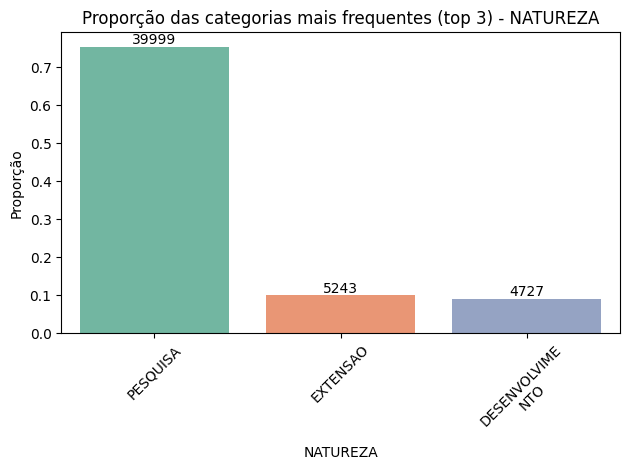

/tmp/ipykernel_32302/81763666.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_sit.set_xticklabels(new_labels, rotation=45)


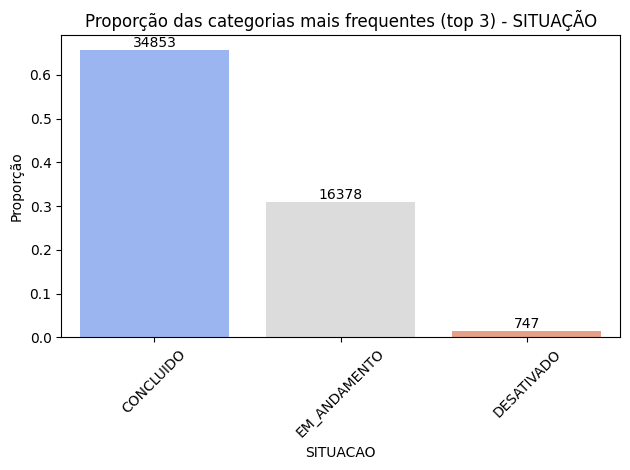

/tmp/ipykernel_32302/81763666.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_inicio = sns.barplot(
/tmp/ipykernel_32302/81763666.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_inicio.set_xticklabels(ax_inicio.get_xticklabels(), rotation=45)


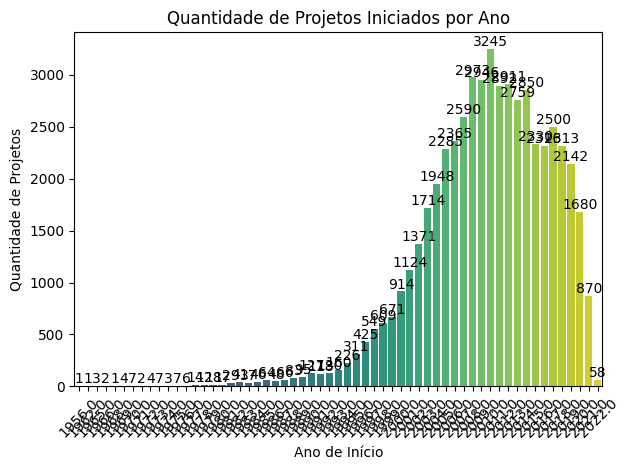

/tmp/ipykernel_32302/81763666.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_fim = sns.barplot(
/tmp/ipykernel_32302/81763666.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_fim.set_xticklabels(ax_fim.get_xticklabels(), rotation=45)


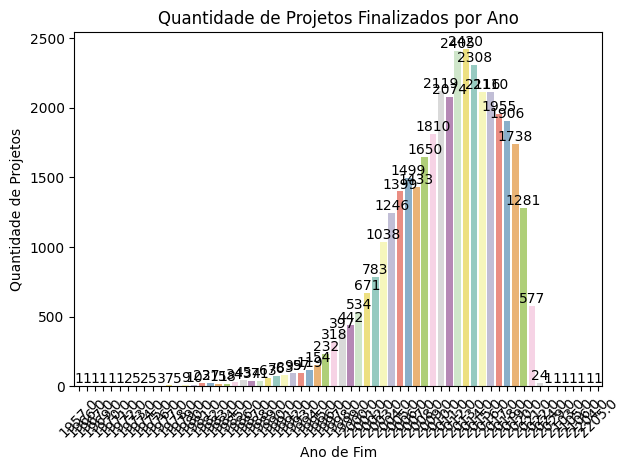

In [46]:
# --------------------------------------------------------------------
# 1. Parâmetro: número de categorias (barras) a exibir para NATUREZA e SITUAÇÃO
# --------------------------------------------------------------------
n = 3  # Ajuste conforme necessário

# --------------------------------------------------------------------
# Função para "quebrar" (wrap) rótulos longos em múltiplas linhas
# --------------------------------------------------------------------
def wrap_labels(label, width=12):
    return "\n".join(textwrap.wrap(label, width=width))

# --------------------------------------------------------------------
# 2. Análise para a Coluna `NATUREZA`
# --------------------------------------------------------------------
df_nat = (
    df_proj
    .groupby("NATUREZA")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(n)
)
df_nat["proportion"] = df_nat["count"] / df_proj.shape[0]

plt.figure()
ax_nat = sns.barplot(
    data=df_nat,
    x="NATUREZA",
    y="proportion",
    hue="NATUREZA",    # usar a própria coluna para colorir cada barra
    palette="Set2"
)
# Remove legenda redundante
if ax_nat.get_legend() is not None:
    ax_nat.get_legend().remove()

plt.title(f"Proporção das categorias mais frequentes (top {n}) - NATUREZA")
plt.xlabel("NATUREZA")
plt.ylabel("Proporção")

# Ajuste dos rótulos do eixo x (rotação + quebra de linha)
new_labels = [wrap_labels(label.get_text(), width=12) for label in ax_nat.get_xticklabels()]
ax_nat.set_xticklabels(new_labels, rotation=45)

# Anota a contagem no topo de cada barra
for patch, (_, row) in zip(ax_nat.patches, df_nat.iterrows()):
    height = patch.get_height()
    ax_nat.annotate(
        f'{int(row["count"])}',
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center', va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

# --------------------------------------------------------------------
# 3. Análise para a Coluna `SITUAÇÃO`
# --------------------------------------------------------------------
df_sit = (
    df_proj
    .groupby("SITUACAO")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(n)
)
df_sit["proportion"] = df_sit["count"] / df_proj.shape[0]

plt.figure()
ax_sit = sns.barplot(
    data=df_sit,
    x="SITUACAO",
    y="proportion",
    hue="SITUACAO",    # usar a própria coluna para colorir cada barra
    palette="coolwarm"
)
# Remove legenda redundante
if ax_sit.get_legend() is not None:
    ax_sit.get_legend().remove()

plt.title(f"Proporção das categorias mais frequentes (top {n}) - SITUAÇÃO")
plt.xlabel("SITUACAO")
plt.ylabel("Proporção")

new_labels = [wrap_labels(label.get_text(), width=12) for label in ax_sit.get_xticklabels()]
ax_sit.set_xticklabels(new_labels, rotation=45)

for patch, (_, row) in zip(ax_sit.patches, df_sit.iterrows()):
    height = patch.get_height()
    ax_sit.annotate(
        f'{int(row["count"])}',
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center', va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

# --------------------------------------------------------------------
# 4. Análise Temporal - ANO-INICIO (Projetos Iniciados)
# --------------------------------------------------------------------
# Agrupamos por ANO-INICIO para ver quantos projetos foram iniciados em cada ano
df_inicio = (
    df_proj
    .dropna(subset=["ANO-INICIO"])     # caso queira ignorar projetos sem ano de início
    .groupby("ANO-INICIO")
    .size()
    .reset_index(name="count_start")
    .sort_values("ANO-INICIO")
)

plt.figure()
ax_inicio = sns.barplot(
    data=df_inicio,
    x="ANO-INICIO",
    y="count_start",
    palette="viridis"
)
plt.title("Quantidade de Projetos Iniciados por Ano")
plt.xlabel("Ano de Início")
plt.ylabel("Quantidade de Projetos")

# Rotação dos rótulos no eixo x (caso tenha muitos anos)
ax_inicio.set_xticklabels(ax_inicio.get_xticklabels(), rotation=45)

# Anota o valor em cima das barras
for patch, (_, row) in zip(ax_inicio.patches, df_inicio.iterrows()):
    height = patch.get_height()
    ax_inicio.annotate(
        f'{int(row["count_start"])}',
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center', va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------
# 5. Análise Temporal - ANO-FIM (Projetos Finalizados)
# --------------------------------------------------------------------
# Agrupamos por ANO-FIM para ver quantos projetos foram finalizados em cada ano
df_fim = (
    df_proj
    .dropna(subset=["ANO-FIM"])       # caso queira ignorar projetos sem ano de término
    .groupby("ANO-FIM")
    .size()
    .reset_index(name="count_end")
    .sort_values("ANO-FIM")
)

plt.figure()
ax_fim = sns.barplot(
    data=df_fim,
    x="ANO-FIM",
    y="count_end",
    palette="Set3"
)
plt.title("Quantidade de Projetos Finalizados por Ano")
plt.xlabel("Ano de Fim")
plt.ylabel("Quantidade de Projetos")

ax_fim.set_xticklabels(ax_fim.get_xticklabels(), rotation=45)

for patch, (_, row) in zip(ax_fim.patches, df_fim.iterrows()):
    height = patch.get_height()
    ax_fim.annotate(
        f'{int(row["count_end"])}',
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center', va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )
plt.tight_layout()
plt.show()

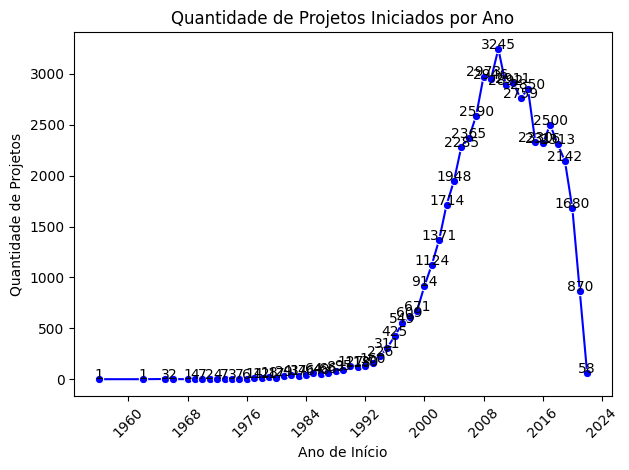

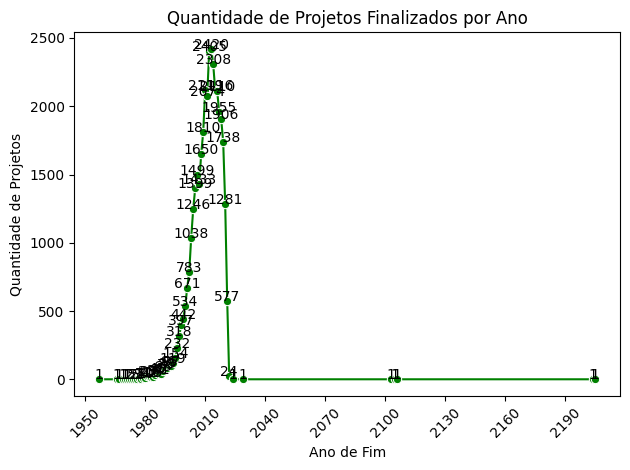

In [48]:
from matplotlib.ticker import MaxNLocator


# ============================================================================
# 2. Análise Temporal para ANO-INICIO e ANO-FIM (Gráficos de linha com eixo contínuo)
# ============================================================================

# --- Projetos Iniciados (ANO-INICIO) ---
df_inicio = (
    df_proj
    .dropna(subset=["ANO-INICIO"])  # ignora projetos sem ano de início, se houver
    .groupby("ANO-INICIO")
    .size()
    .reset_index(name="count_start")
    .sort_values("ANO-INICIO")
)

plt.figure()
ax_inicio = sns.lineplot(
    data=df_inicio,
    x="ANO-INICIO",
    y="count_start",
    marker="o",
    sort=True,
    color="blue"
)
plt.title("Quantidade de Projetos Iniciados por Ano")
plt.xlabel("Ano de Início")
plt.ylabel("Quantidade de Projetos")

# Configura o eixo x como contínuo, limitando o número de ticks (ex.: máximo 10)
ax_inicio.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

# Anota os valores acima dos pontos
for index, row in df_inicio.iterrows():
    plt.text(row["ANO-INICIO"], row["count_start"] + 0.5, int(row["count_start"]), ha='center')

plt.tight_layout()
plt.show()

# --- Projetos Finalizados (ANO-FIM) ---
df_fim = (
    df_proj
    .dropna(subset=["ANO-FIM"])  # ignora projetos sem ano de fim, se houver
    .groupby("ANO-FIM")
    .size()
    .reset_index(name="count_end")
    .sort_values("ANO-FIM")
)

plt.figure()
ax_fim = sns.lineplot(
    data=df_fim,
    x="ANO-FIM",
    y="count_end",
    marker="o",
    sort=True,
    color="green"
)
plt.title("Quantidade de Projetos Finalizados por Ano")
plt.xlabel("Ano de Fim")
plt.ylabel("Quantidade de Projetos")

ax_fim.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

for index, row in df_fim.iterrows():
    plt.text(row["ANO-FIM"], row["count_end"] + 0.5, int(row["count_end"]), ha='center')

plt.tight_layout()
plt.show()

In [ ]:
para

# Grafo geolocalizado

In [ ]:
# pesquisadores unicos na rede de coautoria
list_co = df_co.author1.tolist() + df_co.author2.tolist()
list_co_unique = set(list_co)
list_co_unique = [int(co.replace('LattesID_','')) for co in list_co_unique]
len(list_co_unique)

In [ ]:
# lista de pesquisadores relevantes
rel_pesq = list(df_pesq.LattesID.unique())

In [ ]:
df_end =df_end[df_end.LattesID.isin(list_co_unique)]
df_end

In [ ]:
# import requests
# from geopy.geocoders import Nominatim

# def get_coordinates_from_cep(cep):
#     # Formatar o CEP
#     cep = cep.replace("-", "").strip()
    
#     # Obter o endereço pelo ViaCEP
#     via_cep_url = f"https://viacep.com.br/ws/{cep}/json/"
#     response = requests.get(via_cep_url)
    
#     if response.status_code != 200:
#         return f"Erro ao buscar o CEP: {response.status_code}"
    
#     address_data = response.json()
    
#     if "erro" in address_data:
#         return None
    
#     # Concatenar o endereço completo
#     address = f"{address_data['logradouro']}, {address_data['bairro']}, {address_data['localidade']}, {address_data['uf']}, Brasil"
    
#     # Utilizar o geopy para obter coordenadas
#     geolocator = Nominatim(user_agent="cep_to_coordinates")
#     location = geolocator.geocode(address)
    
#     if location:
#         return (location.latitude, location.longitude)
#     else:
#         return None

# df_end[['latitude','longitude']] = df_end.CEP.progress_apply(lambda x: get_coordinates_from_cep(x))


In [ ]:
# # Reutilizar o geolocator
# geolocator = Nominatim(user_agent="cep_to_coordinates")

# # Dicionário para cache
# cache = {}

# def get_coordinates_from_cep(cep):

#     if type(cep) != str: return None
    
#     # Formatar o CEP
#     cep = cep.replace("-", "").strip()
    
#     # Verificar cache
#     if cep in cache:
#         return cache[cep]
    
#     # Obter o endereço pelo ViaCEP
#     via_cep_url = f"https://viacep.com.br/ws/{cep}/json/"
#     response = requests.get(via_cep_url)
    
#     if response.status_code != 200:
#         return None
    
#     address_data = response.json()
    
#     if "erro" in address_data:
#         return None
    
#     # Concatenar o endereço completo
#     address = f"{address_data.get('logradouro', '')}, {address_data.get('bairro', '')}, {address_data.get('localidade', '')}, {address_data.get('uf', '')}, Brasil"
    
#     # Utilizar o geopy para obter coordenadas
#     try:
#         location = geolocator.geocode(address, timeout=10)
#         if location:
#             coords = (location.latitude, location.longitude)
#             cache[cep] = coords  # Armazenar no cache
#             return coords
#     except Exception as e:
#         return None

#     return None

# # Função para aplicar em paralelo
# def process_row(cep):
#     return get_coordinates_from_cep(cep)

# # Processar os dados em paralelo
# with ThreadPoolExecutor(max_workers=10) as executor:
#     results = list(tqdm(executor.map(process_row, df_end['CEP']), total=len(df_end)))

# # Adicionar as colunas ao dataframe
# df_end['latitude'] = [r[0] if r else None for r in results]
# df_end['longitude'] = [r[1] if r else None for r in results]

COM O GEOPY QUE FUNCIONA 100%, OS OUTROS TOMEI TIMEOUT. TA TUDO COMENTADO PQ DEMORA

In [ ]:
# from geopy.geocoders import Nominatim
# from concurrent.futures import ThreadPoolExecutor
# from tqdm import tqdm

# # Configurar o tqdm para ser usado em pandas
# tqdm.pandas()

# # Reutilizar o geolocator
# geolocator = Nominatim(user_agent="cep_to_coordinates")

# # Dicionário para cache
# cache = {}

# def get_coordinates_from_cep(cep):
#     if not isinstance(cep, str):
#         return None

#     # Formatar o CEP
#     cep = cep.replace("-", "").strip()

#     # Verificar cache
#     if cep in cache:
#         return cache[cep]

#     # Utilizar o geopy para obter coordenadas diretamente pelo CEP
#     try:
#         location = geolocator.geocode(cep, country_codes='BR', timeout=10)  # Restrito ao Brasil
#         if location:
#             coords = (location.latitude, location.longitude)
#             cache[cep] = coords  # Armazenar no cache
#             return coords
#     except Exception as e:
#         return None

#     return None

# # Função para aplicar em paralelo
# def process_row(cep):
#     return get_coordinates_from_cep(cep)


# # Processar os dados em paralelo
# with ThreadPoolExecutor(max_workers=10) as executor:
#     results = list(tqdm(executor.map(process_row, df_end['CEP']), total=Métricas locais para o nó LattesID_1689147340536405:
Degree Centrality: 0.004059962523422861
Closeness Centrality: 0.18920079828668013
Betweenness Centrality: 0.0021029020406970926
PageRank: 0.0003510190051606145
Local Clustering Coefficient: 0.05128205128205128len(df_end)))

# # Adicionar as colunas ao dataframe
# df_end['latitude'] = [r[0] if r else None for r in results]
# df_end['longitude'] = [r[1] if r else None for r in results]

# print(df_end)

# df_end.to_csv('../data/processed/aplicacoes/enderecos_lat_long.csv', index = False)

In [ ]:
df_end  = pd.read_csv('../data/processed/aplicacoes/enderecos_lat_long.csv')

In [ ]:
df_end.head()

In [ ]:
# parte das observacoes nao foram encontradas, entao vamos remover
df_end = df_end[~(df_end.longitude.isna() | df_end.latitude.isna())]
df_end

In [ ]:
df_end.LattesID = df_end.LattesID.apply(lambda x: f'LattesID_{x}')

In [ ]:
df_end

In [ ]:
# Criar um dicionário de posições baseadas na latitude e longitude
positions = {}
for _, row in df_end.iterrows():
    positions[row['LattesID']] = (row['longitude'], row['latitude'])

# Configurar o mapa do Brasil usando Basemap
plt.figure(figsize=(12, 10))
m = Basemap(
    projection='merc',
    llcrnrlat=-35, urcrnrlat=5,  # Latitudes do Brasil
    llcrnrlon=-75, urcrnrlon=-34,  # Longitudes do Brasil
    resolution='l'
)

m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Converter as posições geográficas dos nós para coordenadas no mapa
mapped_positions = {}
for node, (lon, lat) in positions.items():
    x, y = m(lon, lat)
    mapped_positions[node] = (x, y)

# Plotar as arestas no mapa
for edge in G.edges():
    if edge[0] in mapped_positions and edge[1] in mapped_positions:
        x1, y1 = mapped_positions[edge[0]]
        x2, y2 = mapped_positions[edge[1]]
        plt.plot([x1, x2], [y1, y2], color="blue", alpha=0.2)

# Plotar os nós (autores)
for node, (x, y) in mapped_positions.items():
    plt.plot(x, y, 'ro', markersize=5)

# Adicionar título
plt.title("Grafo de Coautorias no Brasil")
plt.show()

# Metricas de grafos

Segue a definição, interpretação e a referência ao slide onde cada métrica aparece:

---

### **Métricas Locais**
1. **Centralidade de Grau (Degree Centrality)**  
   - **Definição**: Mede o número de conexões diretas de um nó. Em grafos direcionados, pode ser subdividida em grau de entrada e saída.  
   - **Interpretação**: Indica a quantidade de relações diretas de um indivíduo. Quanto maior, mais "popular" ou "influente" o nó.  
   - **Slide**: Slide 10 do arquivo "03_AnaliseEstrutural.pdf".

2. **Centralidade de Proximidade (Closeness Centrality)**  
   - **Definição**: Mede a distância média de um nó a todos os outros nós alcançáveis.  
   - **Interpretação**: Nó com alta centralidade de proximidade pode espalhar informações de forma eficiente pela rede.  
   - **Slide**: Slide 16 do arquivo "03_AnaliseEstrutural.pdf".

3. **Centralidade de Intermediação (Betweenness Centrality)**  
   - **Definição**: Mede quantos caminhos mínimos passam por um nó específico.  
   - **Interpretação**: Identifica nós que atuam como "pontes" ou facilitadores do fluxo de informações na rede.  
   - **Slide**: Slide 20 do arquivo "03_AnaliseEstrutural.pdf".

4. **Centralidade PageRank**  
   - **Definição**: Avalia a importância de um nó com base na importância dos nós que apontam para ele, iterativamente.  
   - **Interpretação**: Nó com alta centralidade PageRank é mais relevante em termos de conectividade influente, como no ranking de páginas na internet.  
   - **Slide**: Slide 24 do arquivo "03_AnaliseEstrutural.pdf".

5. **Coeficiente Local de Agrupamento (Local Clustering Coefficient)**  
   - **Definição**: Mede a probabilidade de os vizinhos de um nó também serem conectados entre si.  
   - **Interpretação**: Indica o quão "coesa" é a vizinhança de um nó. Altos valores sugerem agrupamentos densos.  
   - **Slide**: Slide 28 do arquivo "03_AnaliseEstrutural.pdf".

---

### **Métricas Globais**
1. **Número de Nós**  
   - **Definição**: Contagem de vértices no grafo.  
   - **Interpretação**: Representa o tamanho da rede em termos de participantes/indivíduos.  
   - **Slide**: Slide 8 do arquivo "04_AnaliseEstrutural_globais.pdf".

2. **Número de Arestas**  
   - **Definição**: Contagem de conexões no grafo.  
   - **Interpretação**: Indica o número total de relações presentes.  
   - **Slide**: Slide 9 do arquivo "04_AnaliseEstrutural_globais.pdf".

3. **Grau Médio**  
   - **Definição**: Média dos graus dos vértices no grafo.  
   - **Interpretação**: Quantifica a conectividade média na rede.  
   - **Slide**: Slide 12 do arquivo "04_AnaliseEstrutural_globais.pdf".

4. **Densidade**  
   - **Definição**: Razão entre o número de arestas existentes e o número máximo possível de arestas no grafo.  
   - **Interpretação**: Mede o quão preenchido está o grafo. Redes mais densas possuem maior conectividade.  
   - **Slide**: Slide 15 do arquivo "04_AnaliseEstrutural_globais.pdf".

5. **Número de Componentes Conexos**  
   - **Definição**: Quantidade de subgrafos onde qualquer par de vértices está conectado por um caminho.  
   - **Interpretação**: Mede a fragmentação da rede.  
   - **Slide**: Slide 18 do arquivo "04_AnaliseEstrutural_globais.pdf".

6. **Tamanho do Componente Gigante**  
   - **Definição**: Número de nós no maior componente conexo.  
   - **Interpretação**: Representa a maior parte da rede conectada. Um alto valor indica alta coesão.  
   - **Slide**: Slide 22 do arquivo "04_AnaliseEstrutural_globais.pdf".

7. **Tamanho do Clique Máximo**  
   - **Definição**: Número de nós no maior conjunto onde todos estão conectados diretamente entre si.  
   - **Interpretação**: Mede o maior subgrupo totalmente coeso.  
   - **Slide**: Slide 26 do arquivo "04_AnaliseEstrutural_globais.pdf".

8. **Média dos Caminhos Mínimos**  
   - **Definição**: Soma dos menores caminhos entre todos os pares de nós, dividida pelo número de pares.  
   - **Interpretação**: Indica a proximidade média entre os nós.  
   - **Slide**: Slide 30 do arquivo "04_AnaliseEstrutural_globais.pdf".

9. **Diâmetro**  
   - **Definição**: Comprimento do maior caminho mínimo entre quaisquer dois nós do grafo.  
   - **Interpretação**: Mede a extensão máxima da rede.  
   - **Slide**: Slide 34 do arquivo "04_AnaliseEstrutural_globais.pdf".

10. **Assortatividade**  
    - **Definição**: Correlação entre graus dos nós conectados.  
    - **Interpretação**: Mede a tendência de nós com características semelhantes se conectarem.  
    - **Slide**: Slide 38 do arquivo "04_AnaliseEstrutural_globais.pdf".

11. **Coeficiente Global de Agrupamento (Global Clustering Coefficient)**  
    - **Definição**: Razão entre o número de ciclos de tamanho 3 (triângulos) e o número de triplas conectadas na rede.  
    - **Interpretação**: Mede a coesão global da rede.  
    - **Slide**: Slide 42 do arquivo "04_AnaliseEstrutural_globais.pdf".

12. **Centralização (Freeman Centralization)**  
    - **Definição**: Mede a diferença entre a centralidade do nó mais central e dos demais.  
    - **Interpretação**: Indica o grau de dependência da rede em relação ao nó mais central.  
    - **Slide**: Slide 46 do arquivo "04_AnaliseEstrutural_globais.pdf".

13. **Modularidade**  
    - **Definição**: Avalia a força ou qualidade da divisão do grafo em comunidades.  
    - **Interpretação**: Quanto maior, melhor definida está a estrutura modular da rede.  
    - **Slide**: Slide 50 do arquivo "04_AnaliseEstrutural_globais.pdf".

---

Essas métricas abrangem características estruturais importantes, permitindo análises detalhadas sobre propriedades locais e globais da rede. Se precisar de ajuda para calcular alguma delas, posso ajudar!

## Metricas locais

In [ ]:
###################################Métricas locais para o nó LattesID_1689147340536405:
Degree Centrality: 0.004059962523422861
Closeness Centrality: 0.18920079828668013
Betweenness Centrality: 0.0021029020406970926
PageRank: 0.0003510190051606145
Local Clustering Coefficient: 0.05128205128205128
# Métricas locais
metrics_local = {
    "Degree Centrality": nx.degree_centrality(G),
    "Closeness Centrality": nx.closeness_centrality(G),
    "Betweenness Centrality": nx.betweenness_centrality(G),
    "PageRank": nx.pagerank(G),
    "Local Clustering": nx.clustering(G),
}

# Exibindo os resultados
# print("Métricas Locais:")
# for metric, values in metrics_local.items():
#     print(f"{metric}: {values}")



In [ ]:
for metric, lista in metrics_local.items():
    
    # Gerar o histograma
    plt.figure(figsize=(8, 6))
    sns.histplot(lista, kde=False, bins=20)
    plt.title(f"Histograma da métrica: {metric}")
    plt.xlabel("Valores")
    plt.ylabel("Frequência")
    plt.show()

In [ ]:
############################
# Achar nós com as maiores métricas
############################


# Função para encontrar o nó com o maior valor em uma métrica
def find_max_metric(metric_dict):
    return max(metric_dict.items(), key=lambda x: x[1])

# Métricas locais e nó com maior valor
metrics_local = {
    "Degree Centrality": nx.degree_centrality(G),
    "Closeness Centrality": nx.closeness_centrality(G),
    "Betweenness Centrality": nx.betweenness_centrality(G),
    "PageRank": nx.pagerank(G),
    "Local Clustering": nx.clustering(G),
}

# Encontrando os nós com maior valor para cada métrica
max_nodes_local = {metric: find_max_metric(values) for metric, values in metrics_local.items()}

# Exibindo os resultados
print("Nó com maior valor para cada métrica local:")
for metric, (node, value) in max_nodes_local.items():
    print(f"{metric}: Node {node} com valor {value}")

In [ ]:
############################
# Achar nós com as maiores métricas
############################

def get_node_metrics(G, node_name):
    """
    Retorna as métricas locais de um nó específico em um grafo.

    Parâmetros:
        G (networkx.Graph): O grafo.
        node_name: O nome do nó para o qual calcular as métricas.

    Retorna:
        dict: Um dicionário contendo as métricas locais do nó.
    """
    # Verifica se o nó existe no grafo
    if node_name not in G:
        raise ValueError(f"Nó '{node_name}' não encontrado no grafo.")
    
    # Calcula as métricas locais para o nó
    metrics = {
        "Degree Centrality": nx.degree_centrality(G).get(node_name, 0),
        "Closeness Centrality": nx.closeness_centrality(G).get(node_name, 0),
        "Betweenness Centrality": nx.betweenness_centrality(G).get(node_name, 0),
        "PageRank": nx.pagerank(G).get(node_name, 0),
        "Local Clustering Coefficient": nx.clustering(G).get(node_name, 0),
    }
    return metrics


# Nome do nó desejado
node_name = 'LattesID_1689147340536405'  # Substitua pelo nome do nó que você quer analisar

try:
    metrics = get_node_metrics(G, node_name)
    print(f"Métricas locais para o nó {node_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
except ValueError as e:
    print(e)

## Metricas globais

In [ ]:
import networkx as nx
from statistics import median

# Métricas globais
metrics_global = {
    "Number of Nodes": G.number_of_nodes(),
    "Number of Edges": G.number_of_edges(),
    "Average Degree": sum(dict(G.degree()).values()) / G.number_of_nodes(),
    "Median Degree": median(dict(G.degree()).values()),
    "Density": nx.density(G),
    "Number of Connected Components": nx.number_connected_components(G),
    "Largest Connected Component Size": len(max(nx.connected_components(G), key=len)),
    "Max Clique Size": len(max(nx.find_cliques(G), key=len)),
    "Average Shortest Path Length": nx.average_shortest_path_length(G) if nx.is_connected(G) else None,
    "Diameter": nx.diameter(G) if nx.is_connected(G) else None,
    "Assortativity": nx.degree_assortativity_coefficient(G),
    "Global Clustering": nx.transitivity(G),
}


print("\nMétricas Globais:")
for metric, value in metrics_global.items():
    print(f"{metric}: {value}")


In [ ]:

min_weight_edge = -1


# Configurar o layout do grafo
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1, seed=42)  # 'k' controla a distância entre os nós

# Configurar as arestas com pesos (exibir apenas arestas com peso > 1 para melhor visualização)
edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] > min_weight_edge]
weights = [G[u][v]['weight'] for u, v in edges]

# Desenhar nós
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='skyblue', alpha=0.7)

# Desenhar arestas ponderadas
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[w * 0.2 for w in weights], edge_color='gray', alpha=0.5)

# Adicionar rótulos aos nós (apenas alguns, para evitar poluição visual)
sampled_nodes = dict(list(pos.items())[:50])  # Limita a visualização de rótulos a 50 nós
# nx.draw_networkx_labels(G, sampled_nodes, font_size=6, font_color='black', font_family='sans-serif')

# Ocultar eixos e mostrar o grafo
plt.axis('off')
plt.title("Grafo de Coautorias")
plt.show()